<a href="https://colab.research.google.com/github/linshaochieh2019/test/blob/main/ventilator_baseline_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# v3 
After my first submission (PB1.1). A few things to try out:

high-priority
1.   feature engineering
2.   model structure

something else
1. K-fold technique.
2. R/C values: label encoding or one-hot?
3. How about robust scaler?
4. evenly spaced
5. standard scaler


# v3.1 
v3 baseline got PB1.6. Now trying to add up things one by one and observe the score.

In v3.1, I will add R/C values (label encoding)

*   concat along with LSTM
*   concat after LSTM 




In [2]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import time
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import random_split, DataLoader, Dataset

from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_csv = '/content/drive/MyDrive/Data/ventilator1/train.csv'
train = pd.read_csv(train_csv)
targets = train['pressure'].to_numpy().reshape(-1, 80)

print('# data entries: {}'.format(len(train)))
print('Target shape: {}'.format(targets.shape))

# data entries: 6036000
Target shape: (75450, 80)


In [15]:
# get R/C value
rc_map = train.groupby('breath_id')[['R','C']].mean()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
rc_map['R'] = le.fit_transform(rc_map['R'])
rc_map['C'] = le.fit_transform(rc_map['C'])

In [ ]:
# scale pressure and u_in
from sklearn.preprocessing import StandardScaler

def scaler(df):

  ss_p = StandardScaler()
  ss_p.fit(np.array(df['pressure'])[:, np.newaxis])
  df['pressure'] = ss_p.transform(np.array(df['pressure'])[:, np.newaxis])

  ss_u_in = StandardScaler()
  ss_u_in.fit(np.array(df['u_in'])[:, np.newaxis])
  
  df['u_in'] = ss_u_in.transform(np.array(df['u_in'])[:, np.newaxis])

  return df, ss_p, ss_u_in

#toy, ss_p, ss_u_in = scaler(toy)

# Feature engineering

In [16]:
def create_features(df):
    df = df.copy()
    
    # cumsum
    df['u_in_cumsum'] = df.groupby('breath_id')['u_in'].cumsum()

    # u_in_lag
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']

    # fillna
    df = df.fillna(0.)

    # drop index columns  
    df.drop(['id', 'breath_id', 'R', 'C'], axis=1, inplace=True)
    if 'pressure' in df.columns:
        df.drop('pressure', axis=1, inplace=True)

    return df

In [17]:
train_new = create_features(train)
train_inputs = train_new.to_numpy().reshape(-1, 80, train_new.shape[1])

In [ ]:
class MyDataset(Dataset):
  def __init__(self, input, target):
    self.input = input
    self.target = target
    
  def __getitem__(self, item):
    
    data = {
        'inputs': self.input[item],
        'targets': self.target[item],
    }
    
    return data
  
  def __len__(self):
    return len(self.input)

In [ ]:
dataset = MyDataset(input=train_inputs, target=targets)

split_ratio = 0.9
train_len = int(len(dataset) * split_ratio)
val_len = len(dataset) - train_len

train_set, val_set = random_split(dataset, 
                                  lengths=[train_len, val_len], 
                                  generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size):
        hidden = [512, 128, 32]
        linear_dim = 16
        super().__init__()

        self.lstm1 = nn.LSTM(input_size, hidden[0], batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden[0]*2, hidden[1], batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden[1]*2, hidden[2], batch_first=True, bidirectional=True)

        self.fc1 = nn.Linear(hidden[2]*2, linear_dim)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(linear_dim, 1)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)

        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU running: {}'.format(torch.cuda.get_device_name()))

# Setup model and optimizer
rnn = RNNModel(input_size=6)
rnn.to(device)

GPU running: Tesla P100-PCIE-16GB


RNNModel(
  (lstm1): LSTM(6, 512, batch_first=True, bidirectional=True)
  (lstm2): LSTM(1024, 128, batch_first=True, bidirectional=True)
  (lstm3): LSTM(256, 32, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (selu): SELU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.HuberLoss()
optimizer = optim.Adam(rnn.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, 'min', min_lr=1e-7)

In [ ]:
# training
train_stats = {
    'train_loss': [],
    'val_loss': []
}

best_val_loss = 0.1

for epoch in range(100):
  print('Epoch #{}'.format(epoch))  
  rnn.train()
  train_loss = 0.
  
  for batch in tqdm(train_loader):
    inputs = batch['inputs'].float().to(device)
    targets = batch['targets'].float().to(device)
    logits = rnn(inputs).squeeze()
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    loss = criterion(logits, targets)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()

  avg_train_loss = train_loss / len(train_set)  
  
  # Validation phase
  rnn.eval()
  val_loss = 0.

  with torch.no_grad():
    for batch in val_loader:
      inputs = batch['inputs'].float().to(device)
      targets = batch['targets'].float().to(device)
      logits = rnn(inputs).squeeze()
    
      # calculate loss
      loss = criterion(logits, targets)
      val_loss += loss.item()
      
    avg_val_loss = val_loss / len(val_set)  
    scheduler.step(val_loss)
    print(f"{epoch}  {optimizer.param_groups[0]['lr']}")

    # save model
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      print('Saving model weights ...')
      weights_dir = '/content/drive/MyDrive/Colab Notebooks/ventilator/weights/'
      exp_num = 'v3'
      best_rnn = deepcopy(rnn.state_dict())
      torch.save(best_rnn, weights_dir + exp_num + '_rnn.pt')
      
    print('\n')
    print('train_loss: {:.6f}/ val_loss: {:.6f}'.format(avg_train_loss, avg_val_loss))
    print('\n')

  # save training stats
  train_stats['train_loss'].append(avg_train_loss)
  train_stats['val_loss'].append(avg_val_loss)

Epoch #0


100%|██████████| 266/266 [00:20<00:00, 12.94it/s]


0  0.01
Saving model weights ...


train_loss: 0.017636/ val_loss: 0.015735


Epoch #1


100%|██████████| 266/266 [00:20<00:00, 12.95it/s]


1  0.01
Saving model weights ...


train_loss: 0.008461/ val_loss: 0.005557


Epoch #2


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


2  0.01


train_loss: 0.004972/ val_loss: 0.005926


Epoch #3


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


3  0.01
Saving model weights ...


train_loss: 0.004335/ val_loss: 0.004140


Epoch #4


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


4  0.01


train_loss: 0.003972/ val_loss: 0.004751


Epoch #5


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


5  0.01
Saving model weights ...


train_loss: 0.003569/ val_loss: 0.003782


Epoch #6


100%|██████████| 266/266 [00:20<00:00, 12.93it/s]


6  0.01


train_loss: 0.003549/ val_loss: 0.004567


Epoch #7


100%|██████████| 266/266 [00:20<00:00, 12.94it/s]


7  0.01
Saving model weights ...


train_loss: 0.003353/ val_loss: 0.003389


Epoch #8


100%|██████████| 266/266 [00:20<00:00, 12.93it/s]


8  0.01
Saving model weights ...


train_loss: 0.003201/ val_loss: 0.003178


Epoch #9


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


9  0.01


train_loss: 0.003046/ val_loss: 0.003740


Epoch #10


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


10  0.01
Saving model weights ...


train_loss: 0.003038/ val_loss: 0.003139


Epoch #11


100%|██████████| 266/266 [00:20<00:00, 12.93it/s]


11  0.01
Saving model weights ...


train_loss: 0.003021/ val_loss: 0.003082


Epoch #12


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


12  0.01


train_loss: 0.002909/ val_loss: 0.003644


Epoch #13


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


13  0.01
Saving model weights ...


train_loss: 0.002896/ val_loss: 0.002811


Epoch #14


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


14  0.01


train_loss: 0.002996/ val_loss: 0.003353


Epoch #15


100%|██████████| 266/266 [00:20<00:00, 12.94it/s]


15  0.01


train_loss: 0.002898/ val_loss: 0.002880


Epoch #16


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


16  0.01
Saving model weights ...


train_loss: 0.002748/ val_loss: 0.002776


Epoch #17


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


17  0.01


train_loss: 0.002711/ val_loss: 0.002877


Epoch #18


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


18  0.01


train_loss: 0.002946/ val_loss: 0.002881


Epoch #19


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


19  0.01


train_loss: 0.002846/ val_loss: 0.002854


Epoch #20


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


20  0.01


train_loss: 0.002779/ val_loss: 0.002915


Epoch #21


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


21  0.01


train_loss: 0.002769/ val_loss: 0.002808


Epoch #22


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


22  0.01
Saving model weights ...


train_loss: 0.002679/ val_loss: 0.002748


Epoch #23


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


23  0.01


train_loss: 0.003401/ val_loss: 0.002886


Epoch #24


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


24  0.01


train_loss: 0.002639/ val_loss: 0.002769


Epoch #25


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


25  0.01


train_loss: 0.002861/ val_loss: 0.003056


Epoch #26


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


26  0.01


train_loss: 0.002768/ val_loss: 0.002854


Epoch #27


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


27  0.01
Saving model weights ...


train_loss: 0.002706/ val_loss: 0.002718


Epoch #28


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


28  0.01


train_loss: 0.002753/ val_loss: 0.002921


Epoch #29


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


29  0.01
Saving model weights ...


train_loss: 0.002719/ val_loss: 0.002696


Epoch #30


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


30  0.01


train_loss: 0.002583/ val_loss: 0.002733


Epoch #31


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


31  0.01
Saving model weights ...


train_loss: 0.002518/ val_loss: 0.002530


Epoch #32


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


32  0.01
Saving model weights ...


train_loss: 0.002524/ val_loss: 0.002527


Epoch #33


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


33  0.01


train_loss: 0.002495/ val_loss: 0.002589


Epoch #34


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


34  0.01
Saving model weights ...


train_loss: 0.002597/ val_loss: 0.002519


Epoch #35


100%|██████████| 266/266 [00:20<00:00, 12.86it/s]


35  0.01


train_loss: 0.002504/ val_loss: 0.002834


Epoch #36


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


36  0.01


train_loss: 0.002493/ val_loss: 0.002619


Epoch #37


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


37  0.01


train_loss: 0.002599/ val_loss: 0.003075


Epoch #38


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


38  0.01


train_loss: 0.002757/ val_loss: 0.002568


Epoch #39


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


39  0.01


train_loss: 0.002637/ val_loss: 0.002540


Epoch #40


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


40  0.01
Saving model weights ...


train_loss: 0.002496/ val_loss: 0.002516


Epoch #41


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


41  0.01
Saving model weights ...


train_loss: 0.002507/ val_loss: 0.002515


Epoch #42


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


42  0.01


train_loss: 0.002435/ val_loss: 0.002573


Epoch #43


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


43  0.01


train_loss: 0.002523/ val_loss: 0.002679


Epoch #44


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


44  0.01


train_loss: 0.002521/ val_loss: 0.002589


Epoch #45


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


45  0.01


train_loss: 0.002425/ val_loss: 0.002746


Epoch #46


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


46  0.01


train_loss: 0.002454/ val_loss: 0.002592


Epoch #47


100%|██████████| 266/266 [00:20<00:00, 12.92it/s]


47  0.01


train_loss: 0.003104/ val_loss: 0.002914


Epoch #48


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


48  0.01


train_loss: 0.002605/ val_loss: 0.002796


Epoch #49


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


49  0.01


train_loss: 0.002517/ val_loss: 0.002576


Epoch #50


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


50  0.01


train_loss: 0.002486/ val_loss: 0.002876


Epoch #51


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


51  0.01


train_loss: 0.002604/ val_loss: 0.002708


Epoch #52


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


52  0.001


train_loss: 0.002436/ val_loss: 0.002644


Epoch #53


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


53  0.001
Saving model weights ...


train_loss: 0.002151/ val_loss: 0.002150


Epoch #54


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


54  0.001
Saving model weights ...


train_loss: 0.002019/ val_loss: 0.002097


Epoch #55


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


55  0.001
Saving model weights ...


train_loss: 0.001961/ val_loss: 0.002063


Epoch #56


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


56  0.001
Saving model weights ...


train_loss: 0.001921/ val_loss: 0.002016


Epoch #57


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


57  0.001
Saving model weights ...


train_loss: 0.001893/ val_loss: 0.002010


Epoch #58


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


58  0.001
Saving model weights ...


train_loss: 0.001869/ val_loss: 0.002007


Epoch #59


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


59  0.001
Saving model weights ...


train_loss: 0.001841/ val_loss: 0.001970


Epoch #60


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


60  0.001
Saving model weights ...


train_loss: 0.001820/ val_loss: 0.001962


Epoch #61


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


61  0.001
Saving model weights ...


train_loss: 0.001796/ val_loss: 0.001926


Epoch #62


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


62  0.001
Saving model weights ...


train_loss: 0.001779/ val_loss: 0.001920


Epoch #63


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


63  0.001
Saving model weights ...


train_loss: 0.001759/ val_loss: 0.001904


Epoch #64


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


64  0.001


train_loss: 0.001743/ val_loss: 0.001946


Epoch #65


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


65  0.001
Saving model weights ...


train_loss: 0.001732/ val_loss: 0.001885


Epoch #66


100%|██████████| 266/266 [00:20<00:00, 12.90it/s]


66  0.001


train_loss: 0.001714/ val_loss: 0.001891


Epoch #67


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


67  0.001


train_loss: 0.001699/ val_loss: 0.001887


Epoch #68


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


68  0.001
Saving model weights ...


train_loss: 0.001685/ val_loss: 0.001870


Epoch #69


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


69  0.001
Saving model weights ...


train_loss: 0.001664/ val_loss: 0.001848


Epoch #70


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


70  0.001
Saving model weights ...


train_loss: 0.001653/ val_loss: 0.001842


Epoch #71


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


71  0.001


train_loss: 0.001650/ val_loss: 0.001847


Epoch #72


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


72  0.001
Saving model weights ...


train_loss: 0.001624/ val_loss: 0.001802


Epoch #73


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


73  0.001


train_loss: 0.001612/ val_loss: 0.001809


Epoch #74


100%|██████████| 266/266 [00:20<00:00, 12.91it/s]


74  0.001
Saving model weights ...


train_loss: 0.001603/ val_loss: 0.001786


Epoch #75


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


75  0.001


train_loss: 0.001589/ val_loss: 0.001860


Epoch #76


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


76  0.001
Saving model weights ...


train_loss: 0.001578/ val_loss: 0.001773


Epoch #77


100%|██████████| 266/266 [00:20<00:00, 12.85it/s]


77  0.001
Saving model weights ...


train_loss: 0.001568/ val_loss: 0.001758


Epoch #78


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


78  0.001


train_loss: 0.001550/ val_loss: 0.001786


Epoch #79


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


79  0.001
Saving model weights ...


train_loss: 0.001545/ val_loss: 0.001737


Epoch #80


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


80  0.001


train_loss: 0.001534/ val_loss: 0.001741


Epoch #81


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


81  0.001


train_loss: 0.001522/ val_loss: 0.001769


Epoch #82


100%|██████████| 266/266 [00:20<00:00, 12.86it/s]


82  0.001


train_loss: 0.001515/ val_loss: 0.001740


Epoch #83


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


83  0.001
Saving model weights ...


train_loss: 0.001505/ val_loss: 0.001716


Epoch #84


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


84  0.001
Saving model weights ...


train_loss: 0.001490/ val_loss: 0.001713


Epoch #85


100%|██████████| 266/266 [00:20<00:00, 12.85it/s]


85  0.001
Saving model weights ...


train_loss: 0.001483/ val_loss: 0.001703


Epoch #86


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


86  0.001
Saving model weights ...


train_loss: 0.001465/ val_loss: 0.001694


Epoch #87


100%|██████████| 266/266 [00:20<00:00, 12.84it/s]


87  0.001


train_loss: 0.001459/ val_loss: 0.001694


Epoch #88


100%|██████████| 266/266 [00:20<00:00, 12.86it/s]


88  0.001


train_loss: 0.001455/ val_loss: 0.001703


Epoch #89


100%|██████████| 266/266 [00:20<00:00, 12.85it/s]


89  0.001
Saving model weights ...


train_loss: 0.001455/ val_loss: 0.001661


Epoch #90


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


90  0.001


train_loss: 0.001437/ val_loss: 0.001666


Epoch #91


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


91  0.001
Saving model weights ...


train_loss: 0.001433/ val_loss: 0.001652


Epoch #92


100%|██████████| 266/266 [00:20<00:00, 12.83it/s]


92  0.001


train_loss: 0.001424/ val_loss: 0.001670


Epoch #93


100%|██████████| 266/266 [00:20<00:00, 12.85it/s]


93  0.001
Saving model weights ...


train_loss: 0.001411/ val_loss: 0.001641


Epoch #94


100%|██████████| 266/266 [00:20<00:00, 12.86it/s]


94  0.001
Saving model weights ...


train_loss: 0.001399/ val_loss: 0.001632


Epoch #95


100%|██████████| 266/266 [00:20<00:00, 12.87it/s]


95  0.001


train_loss: 0.001389/ val_loss: 0.001662


Epoch #96


100%|██████████| 266/266 [00:20<00:00, 12.84it/s]


96  0.001
Saving model weights ...


train_loss: 0.001394/ val_loss: 0.001612


Epoch #97


100%|██████████| 266/266 [00:20<00:00, 12.89it/s]


97  0.001


train_loss: 0.001384/ val_loss: 0.001628


Epoch #98


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


98  0.001


train_loss: 0.001375/ val_loss: 0.001640


Epoch #99


100%|██████████| 266/266 [00:20<00:00, 12.88it/s]


99  0.001


train_loss: 0.001365/ val_loss: 0.001614




Best val_loss: 0.015436


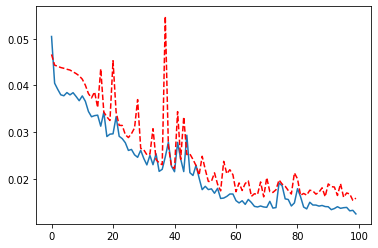

In [ ]:
# plot the training outcome
import matplotlib.pyplot as plt
plt.plot(train_stats['train_loss'])
plt.plot(train_stats['val_loss'], color='red', linestyle='--')

print('Best val_loss: {:.6f}'.format(best_val_loss))